In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import xgboost as xgb

In [32]:
#  Load dataset
df = pd.read_csv(r"C:\Users\ROG\OneDrive\Documents\DeskDump\Python\Parkinsons\pd_speech_features.csv")


# Drop ID column and separate features/target
X = df.drop(columns=['id', 'class'])
y = df['class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.64      0.70        39
           1       0.88      0.94      0.91       113

    accuracy                           0.86       152
   macro avg       0.83      0.79      0.81       152
weighted avg       0.86      0.86      0.86       152


Confusion Matrix:
[[ 25  14]
 [  7 106]]


In [6]:
mse_xgb = mean_squared_error(y_test,y_pred)
print(mse_xgb)

0.13815789473684212


In [7]:
y_train.value_counts()


class
1    451
0    153
Name: count, dtype: int64

In [33]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Check resampled class distribution
print("\nResampled class distribution:")
print(pd.Series(y_train_resampled).value_counts())


Resampled class distribution:
class
1    451
0    451
Name: count, dtype: int64


In [34]:
model.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:12:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.67      0.71        39
           1       0.89      0.93      0.91       113

    accuracy                           0.86       152
   macro avg       0.83      0.80      0.81       152
weighted avg       0.86      0.86      0.86       152


Confusion Matrix:
[[ 26  13]
 [  8 105]]


In [35]:
# from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
# param_grid_xgb = {
#     'lambda': [0.01, 0.1, 1, 10],
#     'gamma': [0, 0.1, 1, 10],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300]
# }

# # GridSearchCV for XGBRegressor (regression task => no accuracy score!)
# grid_search = GridSearchCV(
#     estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
#     param_grid=param_grid_xgb,
#     scoring='neg_mean_squared_error',  # Use appropriate regression metric
#     cv=10,
#     n_jobs=-1
# )

# from sklearn.model_selection import GridSearchCV

# param_grid_xgb = {
#     'lambda': [0.01, 0.1, 1, 10],
#     'gamma': [0, 0.1, 1, 10],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300]
# }

# xgb_reg = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     tree_method='gpu_hist',        # Enable GPU acceleration
#     predictor='gpu_predictor',     # Optional: speeds up prediction too
#     random_state=42
# )

# grid_search = GridSearchCV(
#     estimator=xgb_reg,
#     param_grid=param_grid_xgb,
#     scoring='neg_mean_squared_error',
#     cv=10,
#     n_jobs=-1,
#     verbose=2                        # Optional: shows progress
# )

from sklearn.model_selection import RandomizedSearchCV

# Define parameter distribution
param_dist_xgb = {
    'lambda': [0.01, 0.1, 1, 10],
    'gamma': [0, 0.1, 1, 10],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Randomized search using XGBClassifier
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',       # Use 'multi:softprob' for multi-class
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    param_distributions=param_dist_xgb,
    n_iter=20,                 # You can reduce this for faster results
    scoring='f1',              # Or 'accuracy', 'roc_auc', etc., depending on your goal
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Fit the search on training data
random_result = random_search.fit(X_train_resampled, y_train_resampled)

# Display best score and parameters
print(f"Best score: {random_result.best_score_}")
print(f"Best parameters: {random_result.best_params_}")


Fitting 10 folds for each of 20 candidates, totalling 200 fits


c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best score: 0.9687894234443795
Best parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 0}


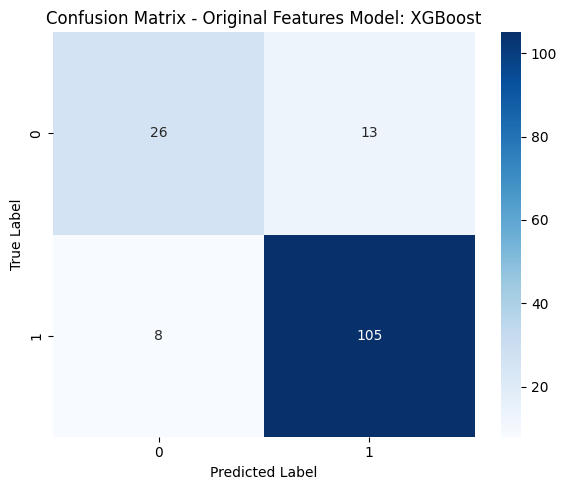

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,         # Show counts
    fmt='d',            # Integer formatting
    cmap='Blues',       # Color map
    cbar=True           # Color bar on the side
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Original Features Model: XGBoost")
plt.tight_layout()
plt.show()


In [37]:
# # Fit on training data (use x_train, y_train instead of full x and y)
# grid_result = grid_search.fit(X_train, y_train)

# # Display the best parameters and the (negative) MSE score
# print(f"Best MSE (negative): {grid_result.best_score_}")
# print(f"Best parameters: {grid_result.best_params_}")
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72        39
           1       0.91      0.89      0.90       113

    accuracy                           0.86       152
   macro avg       0.81      0.82      0.81       152
weighted avg       0.86      0.86      0.86       152



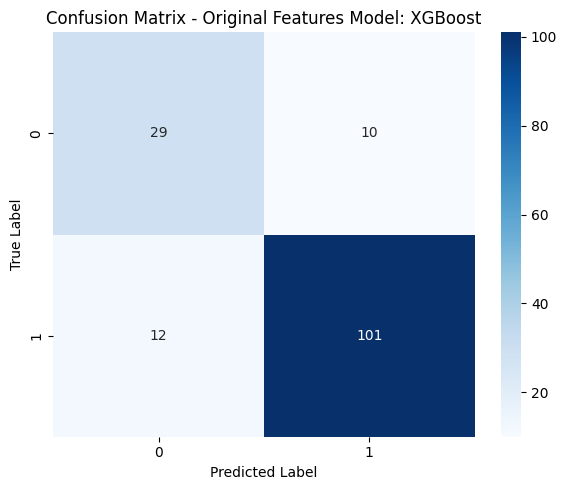

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,         # Show counts
    fmt='d',            # Integer formatting
    cmap='Blues',       # Color map
    cbar=True           # Color bar on the side
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Original Features Model: XGBoost")
plt.tight_layout()
plt.show()


In [12]:
import joblib

# Save the best model to a file
joblib.dump(best_model, 'xgb_parkinson_model.pkl')
print("Model saved as 'xgb_parkinson_model.pkl'")

Model saved as 'xgb_parkinson_model.pkl'


In [13]:
# Load the saved model
loaded_model = joblib.load('xgb_parkinson_model.pkl')

# Use it to predict
y_pred = loaded_model.predict(X_test)


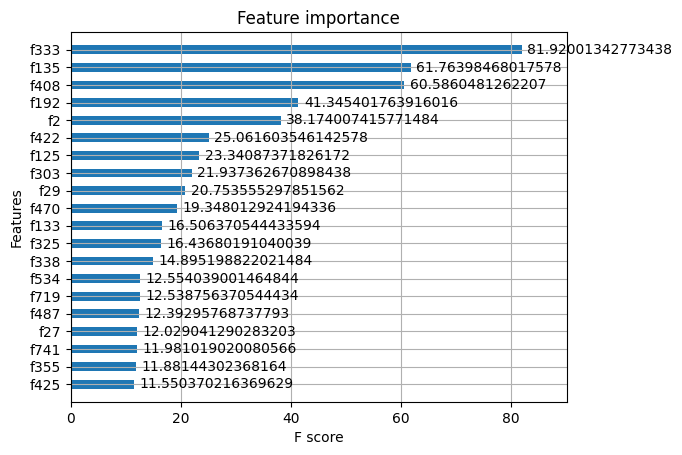

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance

# After fitting your XGBClassifier
xgb_model = best_model  # Or use random_result.best_estimator_

# Plot top 20 important features
plot_importance(xgb_model, max_num_features=20, importance_type='gain', height=0.5)
plt.show()

In [16]:
# Create a DataFrame of features and their importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Show top 30
print(importance_df.head(30))

                        Feature  Importance
333          tqwt_energy_dec_13    0.073287
135         std_9th_delta_delta    0.055255
408     tqwt_entropy_log_dec_16    0.054202
192  app_entropy_shannon_3_coef    0.036988
2                           DFA    0.034151
422     tqwt_entropy_log_dec_30    0.022421
125  std_delta_delta_log_energy    0.020881
303     app_LT_TKEO_mean_3_coef    0.019626
29                           b1    0.018567
470         tqwt_TKEO_std_dec_6    0.017309
133         std_7th_delta_delta    0.014767
325           tqwt_energy_dec_5    0.014705
338          tqwt_energy_dec_18    0.013326
534     tqwt_medianValue_dec_34    0.011231
719    tqwt_kurtosisValue_dec_3    0.011217
487        tqwt_TKEO_std_dec_23    0.011087
27                           f3    0.010761
741   tqwt_kurtosisValue_dec_25    0.010718
355          tqwt_energy_dec_35    0.010629
425     tqwt_entropy_log_dec_33    0.010333
655        tqwt_maxValue_dec_11    0.010319
427     tqwt_entropy_log_dec_35 

In [23]:
import pandas as pd
from xgboost import XGBClassifier

# Ensure x_train has correct column names
X_df = pd.DataFrame(X_train, columns=df.drop(columns=['id', 'class']).columns)  # use original feature names

xgb_model = best_model  # XGBClassifier
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Map XGBoost's 'f0', 'f1', ... to real feature names
feature_map = {f"f{idx}": col for idx, col in enumerate(X_df.columns)}

# Sort and extract top 20
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
top_20_features = [feature_map[fname] for fname, _ in sorted_importance[:20]]

# Create new DataFrame
reduced_df = X_df[top_20_features].copy()
reduced_df['class'] = y_train.values  # Add target column

# Save
reduced_df.to_csv("top_20_features_with_class.csv", index=False)
print("✅ Saved reduced dataset with top 20 features and class.")

✅ Saved reduced dataset with top 20 features and class.


In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import uniform, randint

# 1. Load your dataset
df = pd.read_csv("top_20_features_with_class.csv")
X = df.drop("class", axis=1)
y = df["class"]

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Define pipeline with SMOTE + XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
smote = SMOTE(random_state=42)
pipeline = Pipeline([('smote', smote), ('xgb', model)])

# 4. Define hyperparameter grid for RandomizedSearchCV
param_dist = {
    'xgb__n_estimators': randint(50, 300),
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4),
    'xgb__gamma': uniform(0, 5),
    'xgb__reg_alpha': uniform(0, 1),
    'xgb__reg_lambda': uniform(0, 1)
}

# 5. Randomized search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',  # or 'accuracy', 'roc_auc'
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 6. Fit
random_search.fit(X_train, y_train)

# 7. Evaluate
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("✅ Best parameters:", random_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print(confusion_matrix)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:51:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best parameters: {'xgb__colsample_bytree': np.float64(0.6727299868828402), 'xgb__gamma': np.float64(0.9170225492671691), 'xgb__learning_rate': np.float64(0.07084844859190755), 'xgb__max_depth': 8, 'xgb__n_estimators': 285, 'xgb__reg_alpha': np.float64(0.023062425041415757), 'xgb__reg_lambda': np.float64(0.5247746602583891), 'xgb__subsample': np.float64(0.7599443886861021)}

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        31
           1       0.92      0.94      0.93        90

    accuracy                           0.90       121
   macro avg       0.88      0.86      0.87       121
weighted avg       0.90      0.90      0.90       121



In [25]:
y_train.value_counts()

class
1    361
0    122
Name: count, dtype: int64

In [26]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("\nResampled class distribution:")
print(pd.Series(y_resampled).value_counts())


Resampled class distribution:
class
1    361
0    361
Name: count, dtype: int64


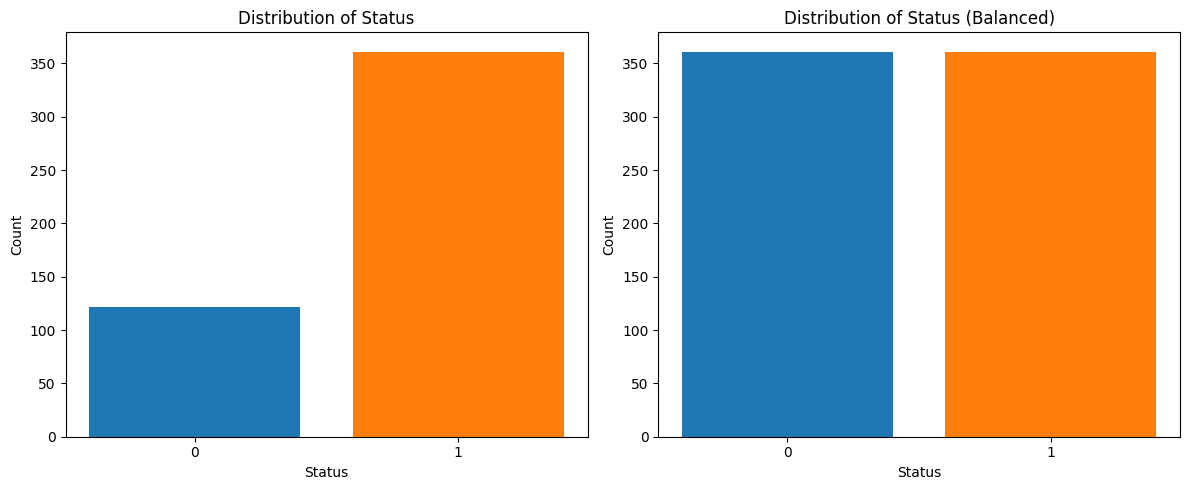

In [27]:
import matplotlib.pyplot as plt

# Counts before balancing
count_before = {0: 122, 1: 361}

# Counts after balancing (e.g., SMOTE)
count_after = {0: 361, 1: 361}

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Unbalanced Data ---
axes[0].bar(
    count_before.keys(),
    count_before.values(),
    color=['#1f77b4', '#ff7f0e']
)
axes[0].set_title('Distribution of Status')
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])

# --- Plot 2: Balanced Data ---
axes[1].bar(
    count_after.keys(),
    count_after.values(),
    color=['#1f77b4', '#ff7f0e']
)
axes[1].set_title('Distribution of Status (Balanced)')
axes[1].set_xlabel('Status')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


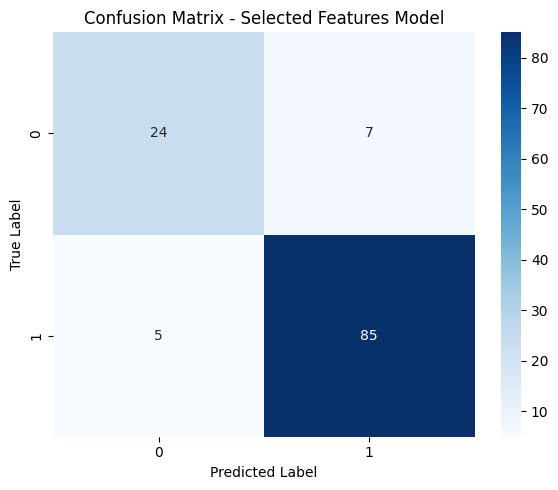

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,         # Show counts
    fmt='d',            # Integer formatting
    cmap='Blues',       # Color map
    cbar=True           # Color bar on the side
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Selected Features Model")
plt.tight_layout()
plt.show()
